# Setting

In [1]:
from utility import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') 

In [3]:
root = os.path.join(os.getcwd(), 'DATA')

In [4]:
color_palette = 'Set2'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

# Import Data

In [5]:
#df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx')) 
df_train = df_raw.copy()

In [6]:
df_train.columns = ['기준일','제품구분','제조국','수출국','수입용도','중분류명 카테고리','어종','상세어종','수입형태','평균단가($)'] # 컬럼명을 한국어로 변경

In [7]:
df_train.head()

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($)
0,2015-12-28,수산물,아르헨티나,아르헨티나,판매용,갑각류,새우,아르헨티나붉은새우,냉동,7.480000
1,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,냉동,2.920000
2,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,"냉동,절단",3.356352
3,2015-12-28,수산물,칠레,칠레,판매용,패류 멍게류,해삼,해삼,"건조,자숙",18.260870
4,2015-12-28,수산물,중국,중국,판매용,어류,서대 박대 페루다,서대,냉동,4.791340


## 평균단가
- Target Value

In [8]:
df_train['평균단가($)'].describe()

count    42073.000000
mean         9.545346
std         21.914624
min          0.203770
25%          2.654165
50%          5.165478
75%          9.929108
max       1522.038402
Name: 평균단가($), dtype: float64

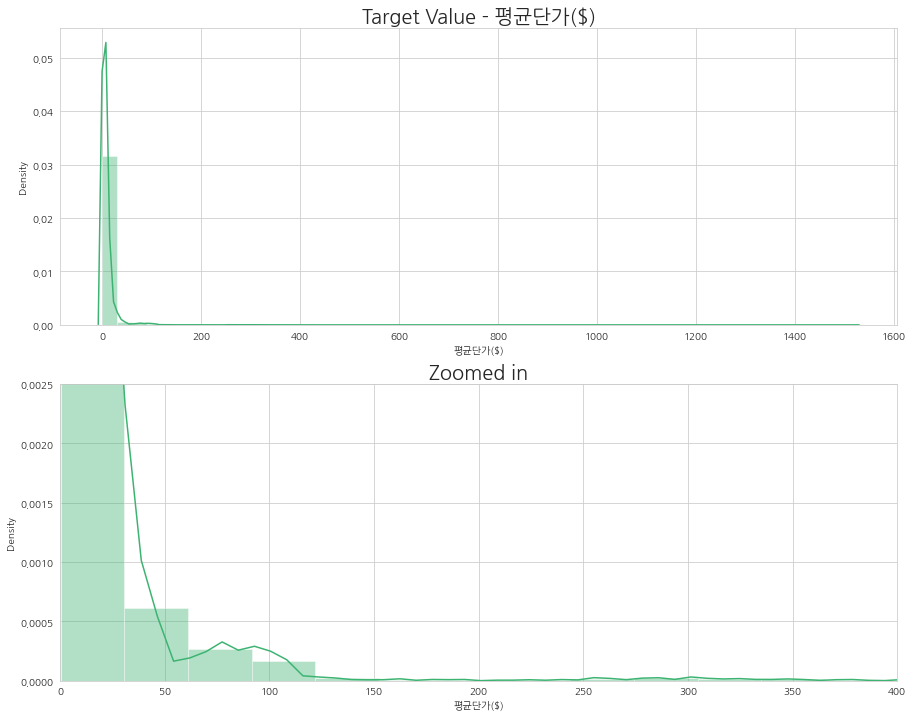

In [9]:
# 평균단가 분포

plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
sns.distplot(df_train['평균단가($)'], color='mediumseagreen')
plt.title("Target Value - 평균단가($)",fontsize=title_size)

plt.subplot(2, 1, 2)
sns.distplot(df_train['평균단가($)'], color='mediumseagreen')
plt.xlim([0, 400])
plt.ylim([0, 0.0025])
plt.title("Zoomed in",fontsize=title_size)

plt.show()

- 평균, Q1, Q2, Q3 값에 비해 최대값이 매우 크고, std가 굉장히 큰 것으로 보아 치우쳐져서 분포하고 있음을 알 수 있음.

- 75%의 값들은 10 미만

- 대부분의 값들이 50 보다 작은 값을 가지고 있음

- 큰 값들의 공통점을 찾아보면 좋을 듯함.

## 기준일

In [10]:
df_train[['기준일']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42073 entries, 0 to 42072
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     42073 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 328.8 KB


In [11]:
df_train['기준일'].describe()

count                   42073
unique                    210
top       2017-09-25 00:00:00
freq                      255
first     2015-12-28 00:00:00
last      2019-12-30 00:00:00
Name: 기준일, dtype: object

In [12]:
print(len(df_train), "data exists between", min(df_train['기준일']), "~", max(df_train['기준일']))

42073 data exists between 2015-12-28 00:00:00 ~ 2019-12-30 00:00:00


In [13]:
df_train['date'] = df_train['기준일'].dt.year.astype('str') + df_train['기준일'].dt.month.astype('str').str.zfill(2)

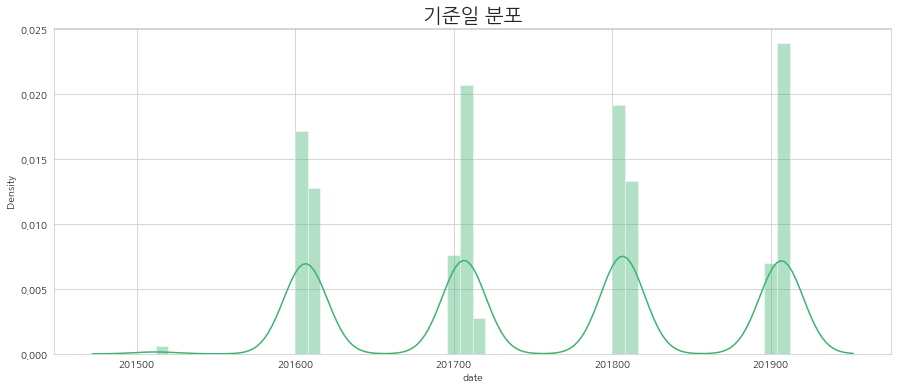

In [14]:
# 년월 기준 기준일 분포

plt.figure(figsize=(15,6))
sns.distplot( df_train['date'], color='mediumseagreen')
plt.title("기준일 분포",fontsize=title_size)
plt.show()

In [15]:
df_train.groupby(df_train['기준일'].dt.year).count() 

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($),date
기준일,,,,,,,,,,,
2015,199,199,199,199,199,199,199,199,199,199,199
2016,10086,10086,10086,10086,10086,10086,10086,10086,10086,10086,10086
2017,10451,10451,10451,10451,10451,10451,10451,10451,10451,10451,10451
2018,10934,10934,10934,10934,10934,10934,10934,10934,10934,10934,10934
2019,10403,10403,10403,10403,10403,10403,10403,10403,10403,10403,10403


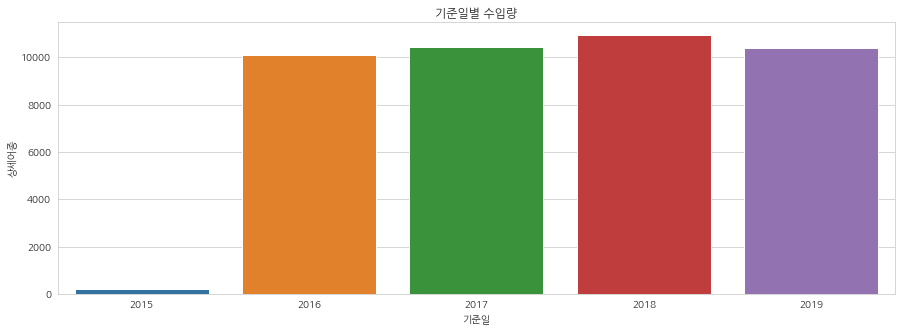

In [16]:
# 기준일별 수입량

plt.figure(figsize=(15,5))
sns.barplot(x = df_train.groupby(df_train['기준일'].dt.year).count().index, y = df_train.groupby(df_train['기준일'].dt.year).count()['상세어종'])
plt.title('기준일별 수입량')
plt.show() 

데이터가 얼마 없는 2015년을 제외한 나머지 년도에선 수입량이 비슷한 것을 알 수 있다.

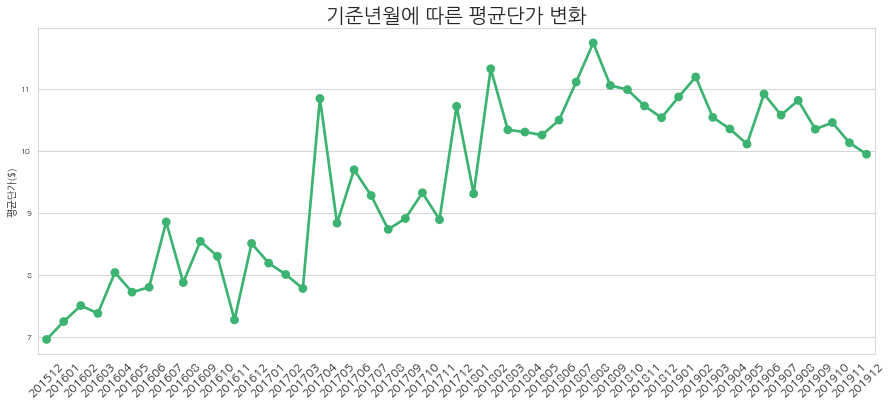

In [17]:
# 기준년월에 따른 평균단가 변화

plt.figure(figsize=(15, 6))
sns.pointplot(x='date', y='평균단가($)', data=df_train, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('기준년월에 따른 평균단가 변화', fontsize=title_size)
plt.show()

- 시간이 지날수록 평균단가가 상승하는 패턴을 보임.

- 2016~2019년 수입량의 큰 차이가 없음에도 평균단가가 상승하는 것으로 보아, 평균단가가 높은 어종의 수입이 상대적으로 증가한 것을 유추해볼 수 있음.

- 가격이 높아지거나 낮아지는 특정 시점들이 존재하지만, 시점들 간의 뚜렷한 패턴이 보이지는 않음.

- 수입형태별 평균단가, 어종별 평균단가처럼 좀 더 세분화해서 볼 필요가 있어보임.

## 제조국 / 수출국

In [18]:
df_train['제조국'].describe()

count     42073
unique       87
top          중국
freq      11029
Name: 제조국, dtype: object

In [19]:
df_train['수출국'].describe()

count     42073
unique       88
top          중국
freq      12008
Name: 수출국, dtype: object

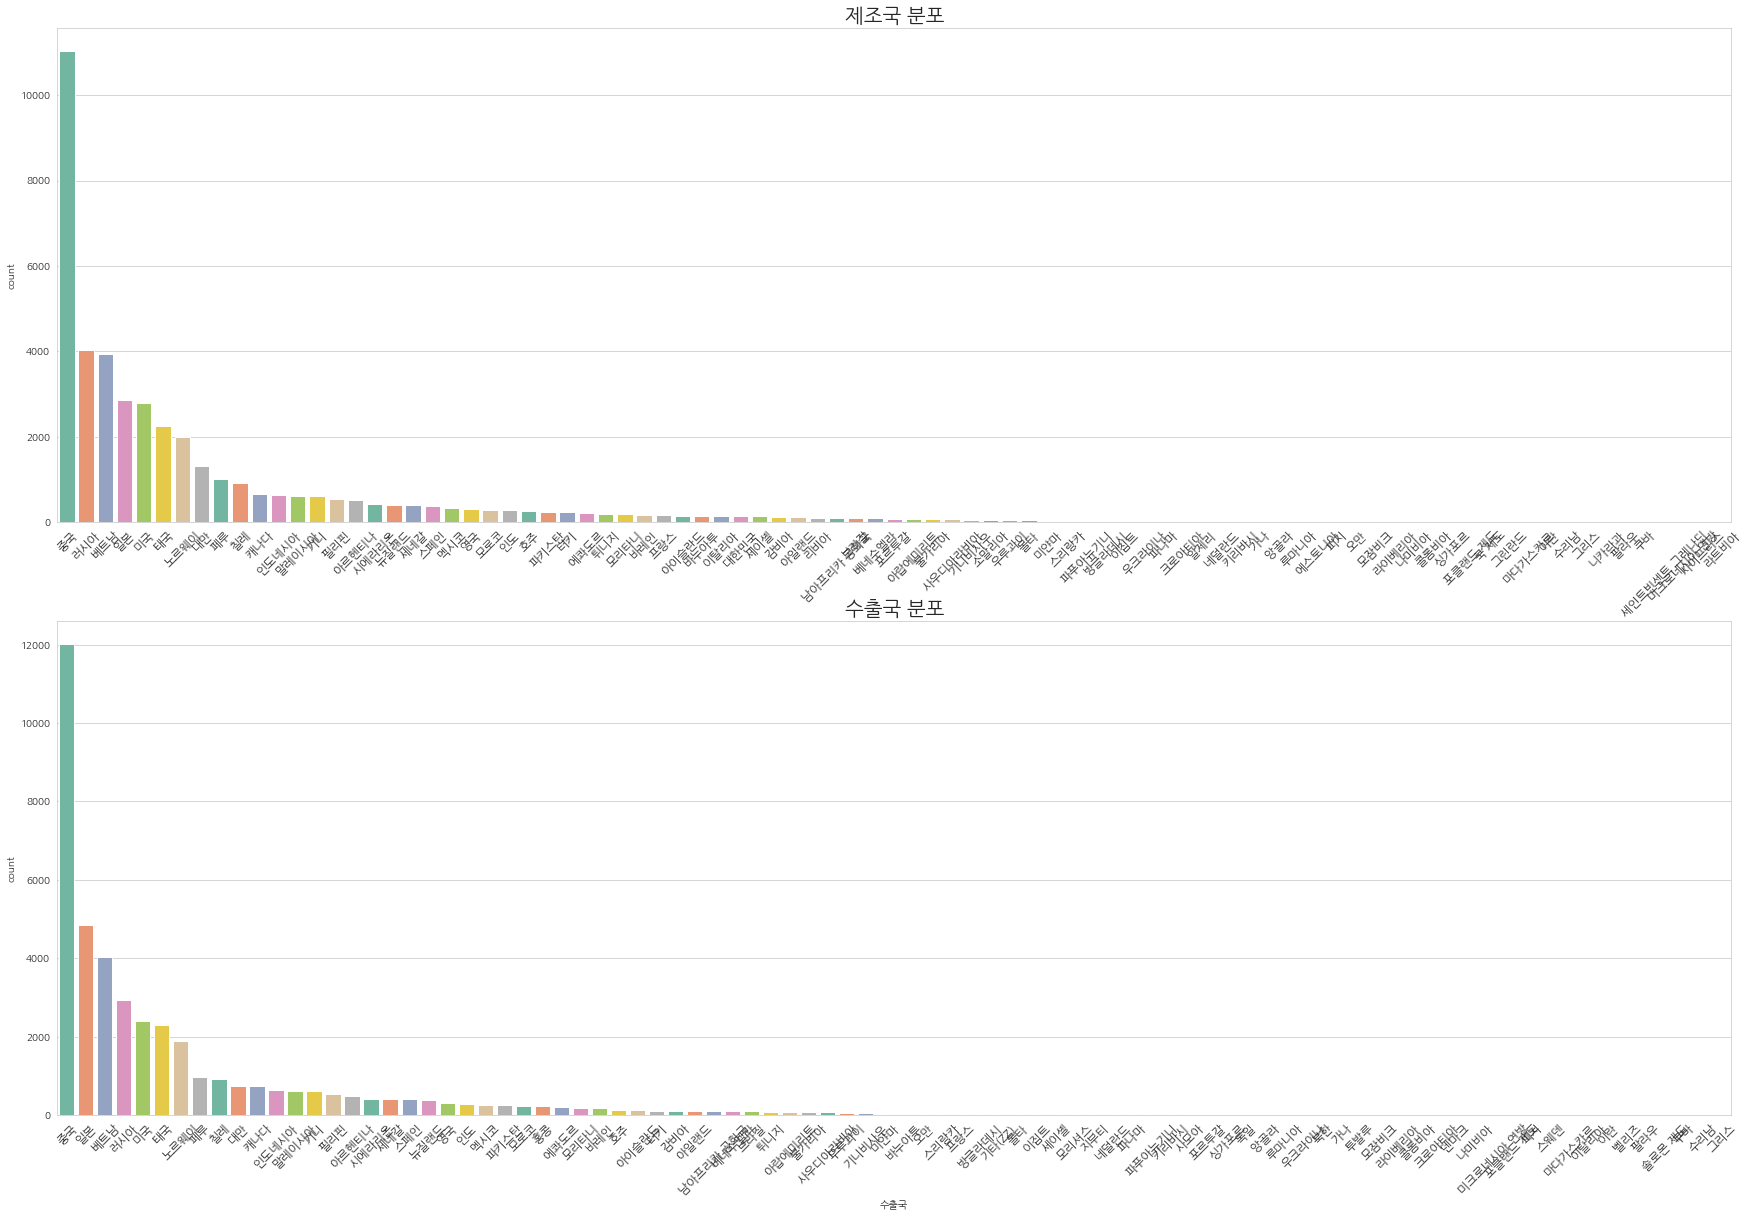

In [20]:
# 제조국 분포

plt.figure(figsize=(30, 20))

plt.subplot(2, 1, 1)
sns.countplot(df_train['제조국'].astype('str').sort_values(), palette=color_palette, order = df_train['제조국'].value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('제조국 분포', fontsize=title_size)

# 수출국 분포

plt.subplot(2, 1, 2)
sns.countplot(df_train['수출국'].astype('str').sort_values(), palette=color_palette, order = df_train['수출국'].value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('수출국 분포', fontsize=title_size)

plt.show()

- 모든 수산물에 대한 제조국, 수출국 분포 그래프

- 제조국, 수출국 모두 가장 비중이 높은 나라는 중국.

- 그 외에, 제조국은 러시아, 베트남,일본, 미국, 태국, 노르웨이 순으로 비중이 높으며, 수출국은 일본, 베트남, 러시아, 미국, 태국, 노르웨이 순으로 비중이 높음.

- 상위 제조국, 수출국 분포는 유사한 것을 알 수 있음.


In [21]:
# df_train['제조국'] = df_train['제조국'].astype('category')
# df_train['수출국'] = df_train['수출국'].astype('category')

In [22]:
# plt.figure(figsize=(30, 30))
# sns.boxplot(x='제조국', y='평균단가($)', data=df_train, palette=color_palette)
# plt.xticks(rotation=60, fontsize=12)
# plt.title('제조국', fontsize=title_size)

## 수입용도

In [23]:
df_train.수입용도.describe()

count     42073
unique        5
top         판매용
freq      39278
Name: 수입용도, dtype: object

In [24]:
print(df_train.수입용도.value_counts())

판매용         39278
자사제품제조용      1726
외화획득용 원료      911
합작            144
반송품(기타)        14
Name: 수입용도, dtype: int64


In [25]:
df_train['수입용도'] = df_train['수입용도'].astype('category')

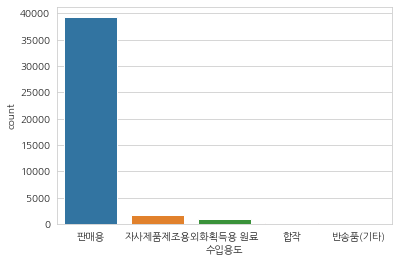

In [26]:
# 수입용도 분포

sns.countplot(x='수입용도',data = df_train, order = df_train['수입용도'].value_counts().index)
plt.show()

- 수입용도는 판매용, 자사제품제조용, 외화획득용 원료, 합작, 반송품(기타) 순으로 많음.

- 판매용에 값이 몰려있어 해당 컬럼을 변수로 사용 시 고려해야함.

##중분류명

In [27]:
df_train['중분류명 카테고리'].describe()

count     42073
unique        7
top          어류
freq      21339
Name: 중분류명 카테고리, dtype: object

In [28]:
df_train['중분류명 카테고리'].value_counts()

어류             21339
갑각류             7298
연체류 해물모듬        6772
패류 멍게류          5097
알 곤이류           1037
젓갈류 해조류 해파리      467
기타 수입식품           63
Name: 중분류명 카테고리, dtype: int64

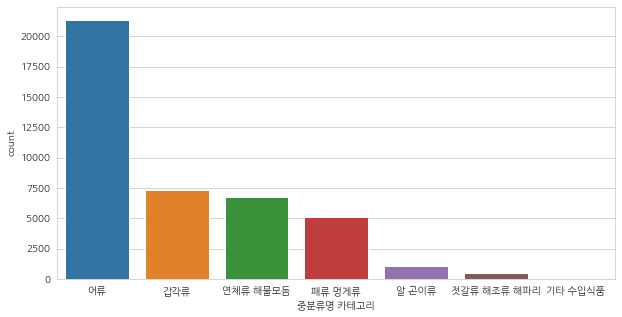

In [29]:
# 중분류명 카테고리 분포

plt.figure(figsize=(10,5))
sns.countplot(x='중분류명 카테고리',data = df_train, order = df_train['중분류명 카테고리'].value_counts().index)
plt.show()

- 중분류명 카테고리는 어류, 갑각류, 연체류 해물모듬, 패류 멍게류, 알 곤이류, 젓갈류 해조류 해파리, 기타 수입식품 순으로 많음.

- 어류에 값이 몰려있어 해당 컬럼을 변수로 사용 시 고려해야함.

Text(0.5, 1.0, '어류의 CATEGORY')

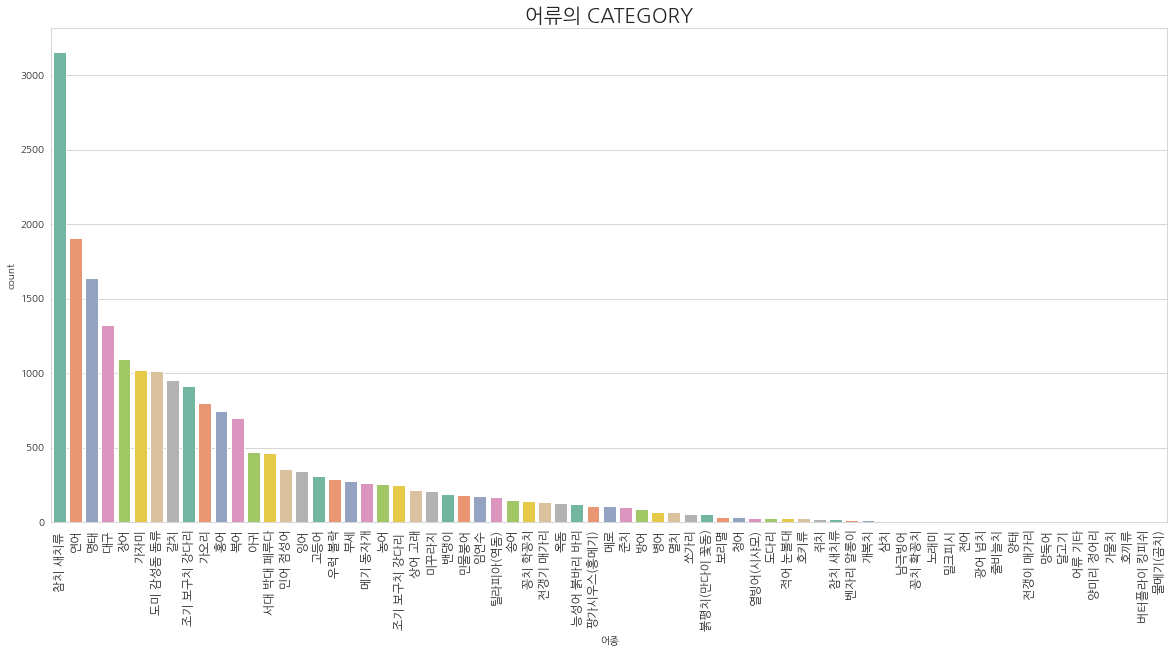

In [30]:
# 어류만 분류
is_fish = df_train['중분류명 카테고리'].str.contains("어류",na=False)
df_fish = df_train[is_fish]

plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
sns.countplot(df_fish['어종'].astype('str').sort_values(), palette=color_palette, order = df_fish['어종'].astype('str').value_counts().index)
plt.xticks(rotation=90, fontsize=12)
plt.title('어류의 CATEGORY', fontsize=title_size)

In [31]:
print(df_fish['어종'].value_counts())

참치 새치류       3159
연어           1905
명태           1640
대구           1325
장어           1093
             ... 
양미리 정어리         2
가물치             1
호끼류             1
버터플라이 킹피쉬       1
물메기(곰치)         1
Name: 어종, Length: 69, dtype: int64


## 수입형태

In [32]:
df_train['수입형태'].describe()

count     42073
unique       78
top          냉동
freq      13568
Name: 수입형태, dtype: object

In [33]:
df_train['수입형태'].value_counts()

냉동                13568
활                  8280
냉장                 4682
냉동,살,자숙            1431
냉동,살               1044
                  ...  
냉동,개아지살,살,포장횟감        2
냉장,간                  1
냉동,자숙,절단,횟감           1
자숙,건조                 1
건조,지느러미,자숙            1
Name: 수입형태, Length: 78, dtype: int64

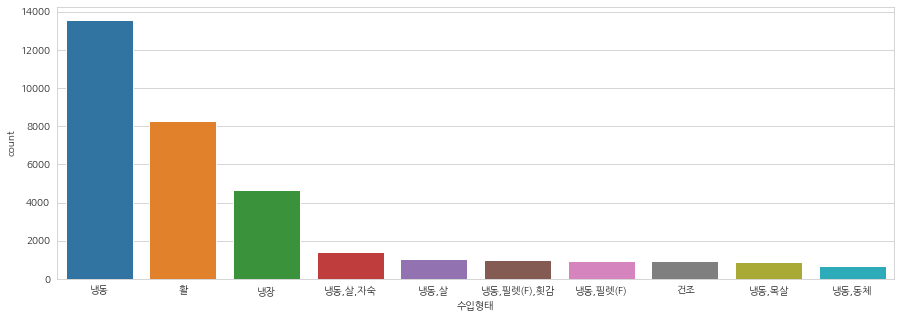

In [34]:
# 수입량 상위 10개 수입형태 분포

plt.figure(figsize=(15,5))
sns.countplot(x='수입형태',data = df_train, order = df_train['수입형태'].value_counts().index[:10])
plt.show()

- 유사한 유형 존재 ex) 머리 / 머리살 / 머리_외화획득용
- 카테고리를 묶을 수 있을지 살펴보기
- 여러개의 용도로 들어오는 경우 존재 -> 용도의 수를 새로운 변수로 고려할 필요 있음

In [35]:
# 수입형태를 세부적으로 분리

import_type_list = set()
for tmp in df_train.수입형태.unique():
    for a in tmp.split(','):
        import_type_list.add(a)

print(*import_type_list)

횟감 살 볼살 개아지살 자숙 머리살 껍질 훈제 다리 목살 난포선 포장횟감 눈살 동체 곤이 절단 냉장 알 지느러미 턱살 필렛(F) 내장 염장 한쪽껍질붙은 간 활 머리 외투막 머리_외화획득용 캐비아대용 줄기 집게다리 냉동 꼬리_외화획득용 슬라이스(S) 건조 창난


## 어종

In [36]:
df_train['어종'].describe()

count     42073
unique      113
top          새우
freq       4141
Name: 어종, dtype: object

In [37]:
# 중분류명 카테고리별 어종, 상세어종

with pd.option_context('display.max_rows', df_train.shape[0]+1):
    display(df_train[['중분류명 카테고리', '어종','상세어종']].groupby(['중분류명 카테고리', '어종','상세어종']).count())

Empty DataFrame
Columns: []
Index: [(갑각류, 가재 랍스타, 민물가재), (갑각류, 가재 랍스타, 바다가재), (갑각류, 가재 랍스타, 바닷가재), (갑각류, 게, 가시투성왕게), (갑각류, 게, 게), (갑각류, 게, 꽃게), (갑각류, 게, 대게), (갑각류, 게, 던지네스게), (갑각류, 게, 두점박이민꽃게), (갑각류, 게, 민꽃게), (갑각류, 게, 붉은대게), (갑각류, 게, 왕게), (갑각류, 게, 왕게붙이), (갑각류, 게, 은행게), (갑각류, 게, 참게), (갑각류, 게, 털게), (갑각류, 게, 톱날꽃게), (갑각류, 새우, 가시배새우), (갑각류, 새우, 닭새우), (갑각류, 새우, 도화새우), (갑각류, 새우, 매미새우), (갑각류, 새우, 민물새우), (갑각류, 새우, 북쪽분홍새우), (갑각류, 새우, 새뱅이), (갑각류, 새우, 새우), (갑각류, 새우, 아르헨티나붉은새우), (갑각류, 새우, 적새우), (갑각류, 새우, 젓새우), (갑각류, 새우, 큰징거미새우), (갑각류, 새우, 홍다리얼룩새우), (갑각류, 새우, 흰다리새우), (기타 수입식품, 자라, 식용자라), (알 곤이류, 날치알, 날치알), (알 곤이류, 대구알, 대구알), (알 곤이류, 명란(명태알), 명태알), (알 곤이류, 샛돔류알, 샛돔류알), (알 곤이류, 성게알, 성게알), (알 곤이류, 연어알, 연어알), (알 곤이류, 열빙어(시샤모)알, 열빙어알), (알 곤이류, 은민대구알, 은민대구알), (알 곤이류, 청어알, 청어알), (알 곤이류, 호키(새꼬리민태)알, 새꼬리민태알), (어류, 가물치, 가물치), (어류, 가오리, 가오리), (어류, 가자미, 가자미), (어류, 가자미, 각시가자미), (어류, 가자미, 검정가자미), (어류, 가자미, 까지가자미), (어류, 가자미, 돌가자미), (어류, 가자미, 마설가자미), (어류, 가자미, 마소치가자미), (어류, 가자미, 매듭가자미), (어류, 가자미, 뿔가자미), (어류, 가자미, 소주목탁가자미), (어류, 가자미, 장수기름가자미), (어류, 가자미, 첨치가자미), (어류, 갈치, 갈치), (어류, 개복치, 개복치), (어류, 고등어, 고등어), (어류, 광어 넙치, 넙치), (어류, 꽁치 학꽁치, 꽁치), (어류, 꽁치 확꽁치, 학공치), (어류, 남극빙어, 코드아이스피쉬), (어류, 노래미, 쥐노래미), (어류, 농어, 농어), (어류, 농어, 등목어), (어류, 농어, 바라문디), (어류, 능성어 붉바리 바리, 능성어), (어류, 능성어 붉바리 바리, 바리), (어류, 능성어 붉바리 바리, 바리,교잡종), (어류, 능성어 붉바리 바리, 자바리), (어류, 능성어 붉바리 바리, 자이언트그루퍼), (어류, 달고기, 달고기), (어류, 대구, 남방대구), (어류, 대구, 대구), (어류, 대구, 민대구), (어류, 대구, 블루화이팅), (어류, 대구, 은대구), (어류, 대구, 은민대구), (어류, 대구, 청대구), (어류, 도다리, 강도다리), (어류, 도미 감성돔 돔류, 감성돔), (어류, 도미 감성돔 돔류, 강담돔), (어류, 도미 감성돔 돔류, 금눈돔), (어류, 도미 감성돔 돔류, 금색돔), (어류, 도미 감성돔 돔류, 돌돔), (어류, 도미 감성돔 돔류, 돔), (어류, 도미 감성돔 돔류, 동갈돗돔), (어류, 도미 감성돔 돔류, 벵에돔), (어류, 도미 감성돔 돔류, 붉돔), (어류, 도미 감성돔 돔류, 샛돔), (어류, 도미 감성돔 돔류, 실꼬리돔), (어류, 도미 감성돔 돔류, 어름돔), (어류, 도미 감성돔 돔류, 적돔), (어류, 도미 감성돔 돔류, 쥐돔), (어류, 도미 감성돔 돔류, 진홍퉁돔), (어류, 도미 감성돔 돔류, 참돔), (어류, 도미 감성돔 돔류, 황돔), (어류, 도미 감성돔 돔류, 황적퉁돔), (어류, 도미 감성돔 돔류, 흑점샛돔알), ...]

- 중분류명 카테고리, 어종, 상세어종을 Encoding하여 변수로 사용
- 3개 모두 사용할지 일부만 사용할지 가설 설정하여 적용 필요

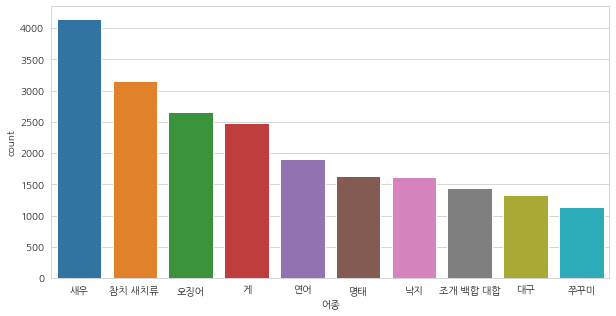

In [38]:
# 수입량 상위 10개 어종 분포

plt.figure(figsize=(10,5))
sns.countplot(x='어종',data = df_train, order = df_train['어종'].value_counts().index[:10])
plt.show()

- 어종은 새우, 참치 새치류, 오징어, 게, 연어 순으로 많음.
- 전체 어종을 모두 고려하여 모델링하거나 주요 어종(오징어,연어,흰다리새우)만을 고려하여 모델링하는 방법 존재
- 어종들 중 주요 어종만 따로 EDA하고자 함.

### 주요 어종 (오징어, 연어, 새우)

#### 오징어

In [127]:
# 오징어만 분류
is_squid = df_train['상세어종'].str.contains("오징어",na=False)
df_squid = df_train[is_squid]

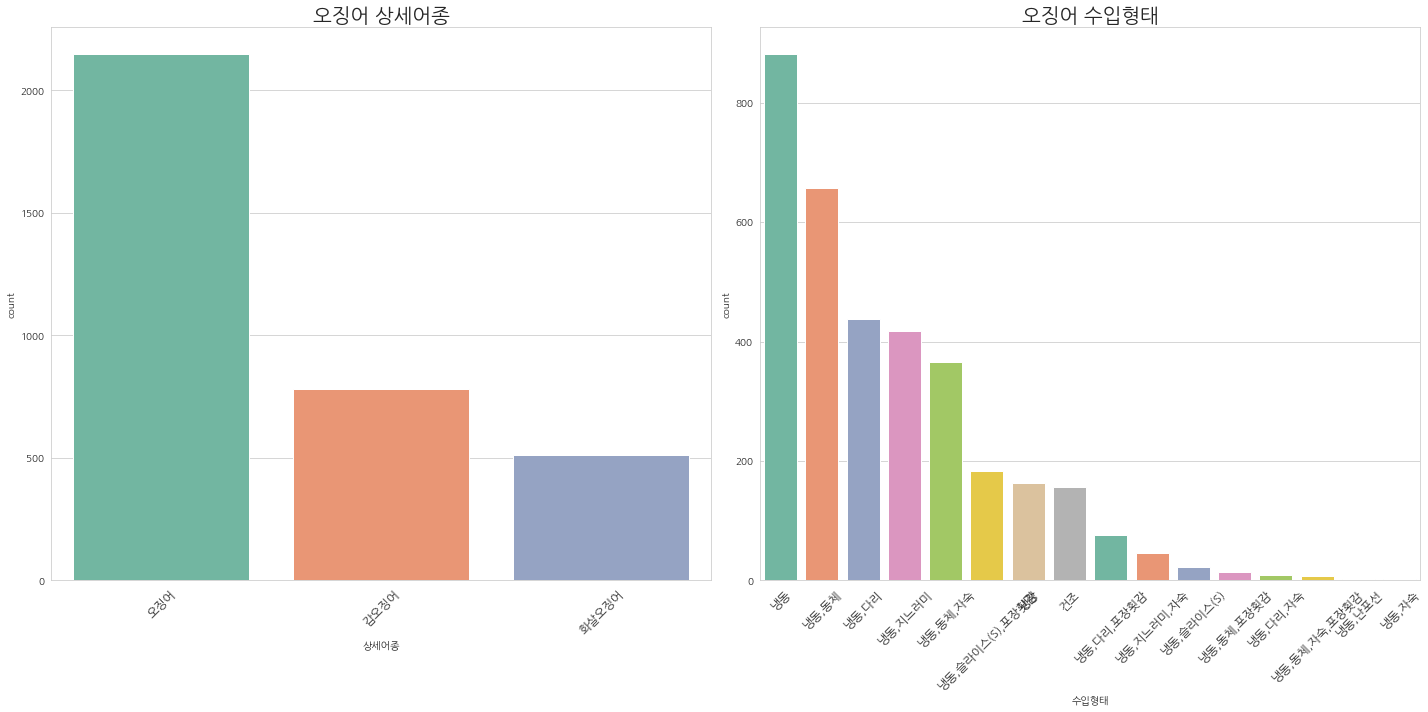

In [130]:
# 오징어 제조국과 수출국 동일 여부 판단

df_squid.loc[df_squid['제조국']==df_squid['수출국'], "comp"] = '같음'
df_squid.loc[df_squid['제조국']!=df_squid['수출국'], "comp"] = '다름'

# 오징어 상세어종 및 수입형태 분포

plt.figure(figsize=(20, 10))

plt.subplot(121)
sns.countplot(df_squid['상세어종'].astype('str').sort_values(), palette=color_palette, order= df_squid['상세어종'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('오징어 상세어종', fontsize=title_size)

plt.subplot(122)
sns.countplot(df_squid['수입형태'].astype('str').sort_values(), palette=color_palette, order= df_squid['수입형태'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('오징어 수입형태', fontsize=title_size)

plt.tight_layout()

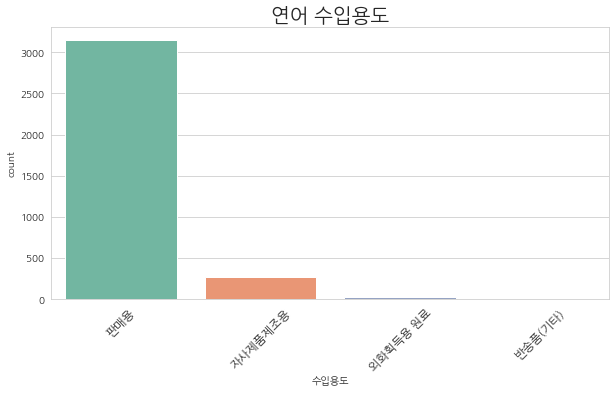

In [131]:
plt.figure(figsize=(10, 5))

sns.countplot(df_squid['수입용도'].astype('str').sort_values(), palette=color_palette, order= df_squid['수입용도'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 수입용도', fontsize=title_size)
plt.show()

In [39]:
# 오징어의 제조국 점유율

df_train[df_train['상세어종']=='오징어']['제조국'].value_counts()/sum(df_train[df_train['상세어종']=='오징어']['제조국'].value_counts()) 

페루       0.384186
중국       0.251163
칠레       0.250233
대만       0.028837
대한민국     0.026512
아르헨티나    0.026047
뉴질랜드     0.020465
러시아      0.003721
미국       0.002791
에콰도르     0.001860
바누아투     0.000930
베트남      0.000930
인도네시아    0.000930
우루과이     0.000930
나미비아     0.000465
Name: 제조국, dtype: float64

In [40]:
# 오징어의 수출국 점유율

df_train[df_train['상세어종']=='오징어']['수출국'].value_counts()/sum(df_train[df_train['상세어종']=='오징어']['수출국'].value_counts()) 

페루           0.370233
중국           0.286977
칠레           0.261395
대만           0.028372
아르헨티나        0.020465
뉴질랜드         0.018140
러시아          0.003721
미국           0.002791
에콰도르         0.001860
일본           0.001395
우루과이         0.000930
베트남          0.000930
인도네시아        0.000930
남아프리카 공화국    0.000465
태국           0.000465
바누아투         0.000465
스페인          0.000465
Name: 수출국, dtype: float64

In [132]:
# 제조국, 수출국 다른곳 찾기

print(df_squid['comp'].value_counts())

같음    3322
다름     123
Name: comp, dtype: int64


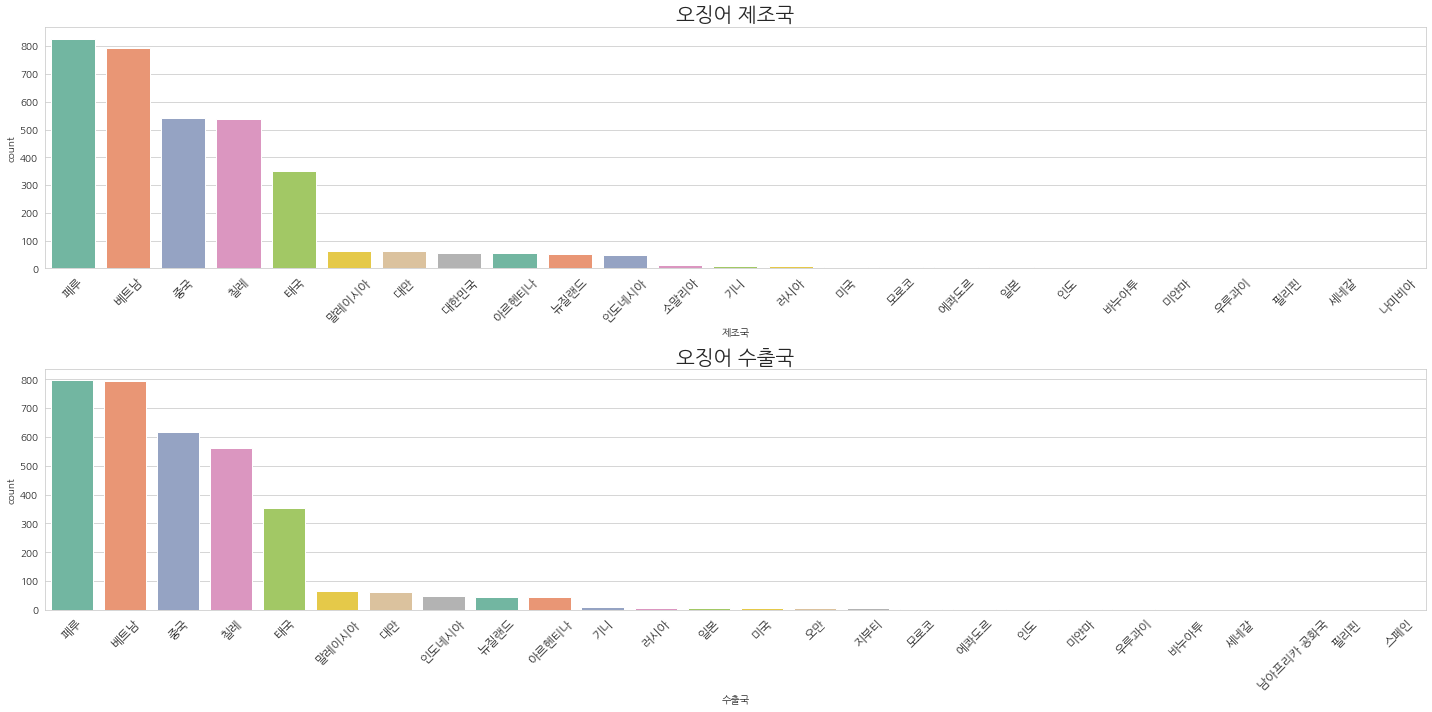

In [138]:
# 오징어 제조국

plt.figure(figsize=(20, 10))

plt.subplot(211)
sns.countplot(df_squid['제조국'].astype('str').sort_values(), palette=color_palette, order = df_squid['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('오징어 제조국', fontsize=title_size)

# 오징어 수출국

plt.subplot(212)
sns.countplot(df_squid['수출국'].astype('str').sort_values(), palette=color_palette, order = df_squid['수출국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('오징어 수출국', fontsize=title_size)

plt.tight_layout()

- 오징어 제조국 및 수출국 점유율
- 오징어 주요 제조국 및 수출국 : 페루,중국,칠레 (91%)
- 주요 수출국별 평균단가를 시각화하여 상관관계를 알아보고자 함.

In [42]:
all_squid_price = df_train[df_train['상세어종']=='오징어'].groupby(by='기준일').mean()['평균단가($)'] # 전체 오징어 평균단가
peru_squid_price = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='페루'].groupby(by='기준일').mean()['평균단가($)'] # 페루 오징어 평균단가
china_squid_price = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='중국'].groupby(by='기준일').mean()['평균단가($)'] # 중국 오징어 평균단가
chile_squid_price = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='칠레'].groupby(by='기준일').mean()['평균단가($)'] # 칠레 오징어 평균단가

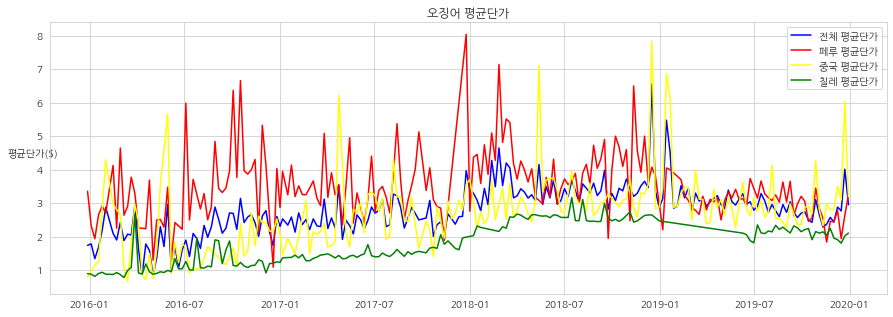

In [43]:
plt.figure(figsize=(15,5))

plt.title('오징어 평균단가')

plt.plot(all_squid_price,color='blue',label='전체 평균단가')
plt.plot(peru_squid_price,color='red',label='페루 평균단가')
plt.plot(china_squid_price,color='yellow',label='중국 평균단가')
plt.plot(chile_squid_price,color='green',label='칠레 평균단가')

plt.legend(loc='best')
plt.ylabel('평균단가($)',rotation=0)

plt.show()

오징어 평균단가는 **주요 수출국들(페루,중국,칠레)의 평균단가와 높은 상관관계**를 가지는 듯함. (올라갈때 같이 올라가고 내려갈때 같이 내려감)

<AxesSubplot:title={'center':'Correlation of Squid Price'}>

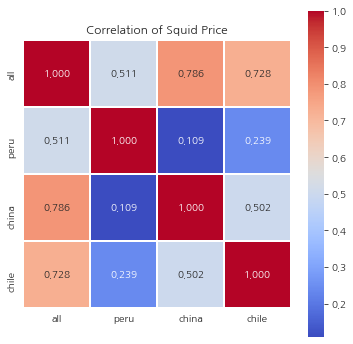

In [112]:
corr = pd.DataFrame({'all':all_squid_price,
             'peru':peru_squid_price,
             'china':china_squid_price,
             'chile':chile_squid_price}).corr()

plt.figure(figsize= (6, 6))
plt.title('Correlation of Squid Price')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

실제로 오징어 평균단가는 페루,중국,칠레 평균단가와 높은 상관관계를 띄고 있음.

In [45]:
all_squid_count = df_train[df_train['상세어종']=='오징어'].groupby(by='기준일')['상세어종'].count() # 전체 오징어 수입량
peru_squid_count = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='페루'].groupby(by='기준일')['상세어종'].count() # 페루 오징어 수입량
china_squid_count = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='중국'].groupby(by='기준일')['상세어종'].count() # 중국 오징어 수입량
chile_squid_count = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='칠레'].groupby(by='기준일')['상세어종'].count() # 칠레 오징어 수입량

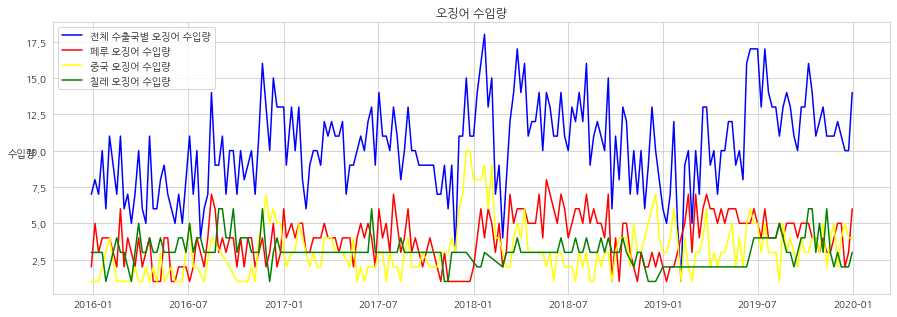

In [46]:
plt.figure(figsize=(15,5))

plt.title('오징어 수입량')

plt.plot(all_squid_count,color='blue',label='전체 수출국별 오징어 수입량')
plt.plot(peru_squid_count,color='red',label='페루 오징어 수입량')
plt.plot(china_squid_count,color='yellow',label='중국 오징어 수입량')
plt.plot(chile_squid_count,color='green',label='칠레 오징어 수입량')


plt.legend(loc='best')
plt.ylabel('수입량',rotation=0)

plt.show()

오징어 수입량 **주요 수출국들(페루,중국,칠레)의 수입량과 어느정도 상관관계**를 보이는 듯함. 특히, 페루와 높은 상관관계를 보이는 듯함.

<AxesSubplot:title={'center':'Correlation of Squid Import Volume'}>

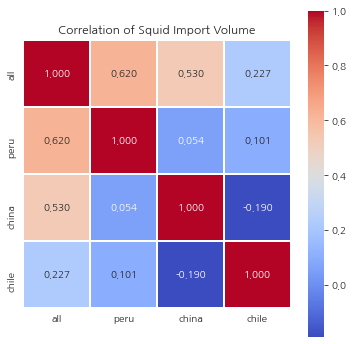

In [111]:
corr = pd.DataFrame({'all':all_squid_count,
             'peru':peru_squid_count,
             'china':china_squid_count,
             'chile':chile_squid_count}).corr()

plt.figure(figsize= (6, 6))
plt.title('Correlation of Squid Import Volume')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

- 실제로 오징어 수입량은 페루,중국 수입량과 높은 상관관계를 띄고 있음.
- 칠레는 상대적으로 낮은 상관관계

#### 연어




In [119]:
# 연어만 분류
is_salmon = df_fish['상세어종'].str.contains("연어",na=False)
df_salmon = df_fish[is_salmon]

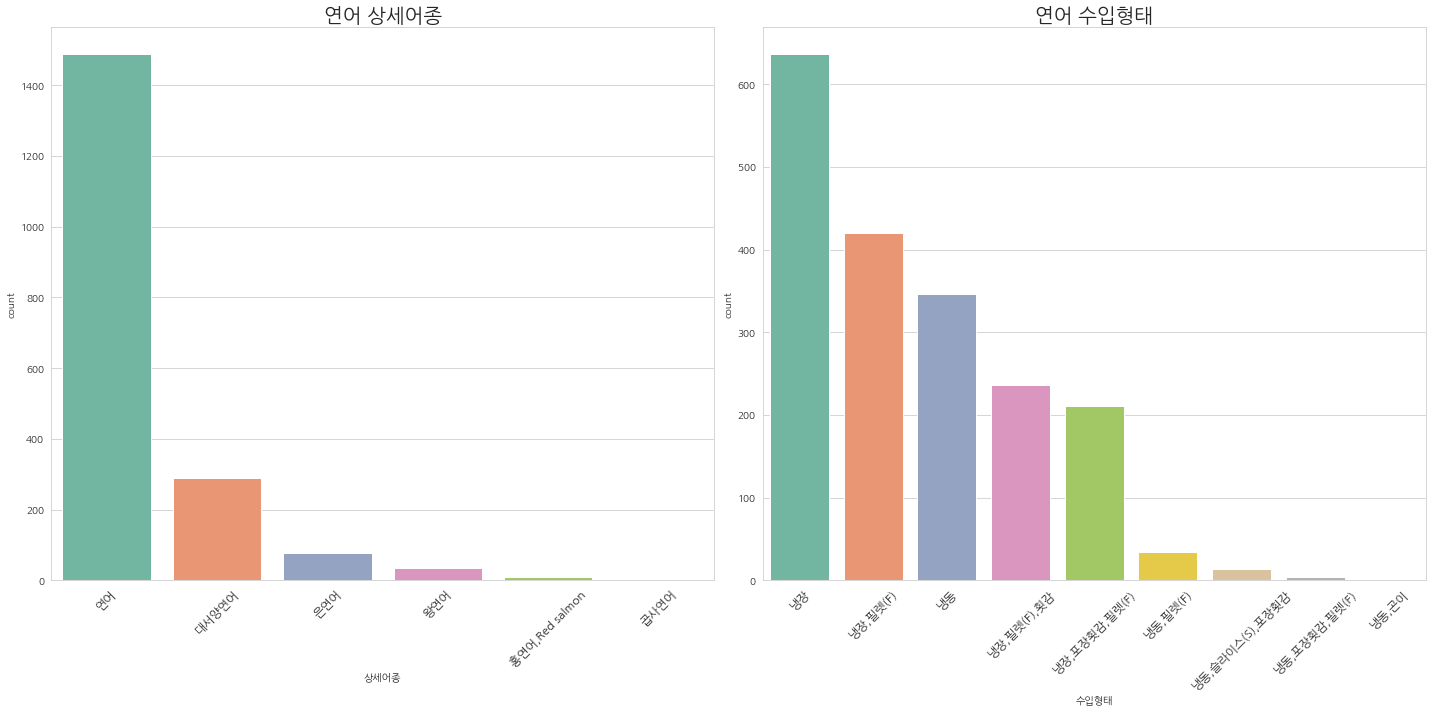

In [120]:
# 연어 제조국과 수출국 동일여부 판단

df_salmon.loc[df_salmon['제조국']==df_salmon['수출국'], "comp"] = '같음'
df_salmon.loc[df_salmon['제조국']!=df_salmon['수출국'], "comp"] = '다름'

# 연어 상세어종 및 수입형태 분포

plt.figure(figsize=(20, 10))

plt.subplot(121)
sns.countplot(df_salmon['상세어종'].astype('str').sort_values(), palette=color_palette, order= df_salmon['상세어종'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 상세어종', fontsize=title_size)

plt.subplot(122)
sns.countplot(df_salmon['수입형태'].astype('str').sort_values(), palette=color_palette, order= df_salmon['수입형태'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 수입형태', fontsize=title_size)

plt.tight_layout()

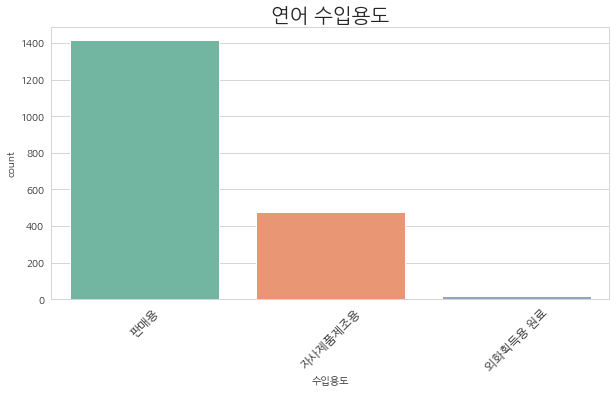

In [116]:
plt.figure(figsize=(10, 5))

sns.countplot(df_salmon['수입용도'].astype('str').sort_values(), palette=color_palette, order= df_salmon['수입용도'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 수입용도', fontsize=title_size)
plt.show()

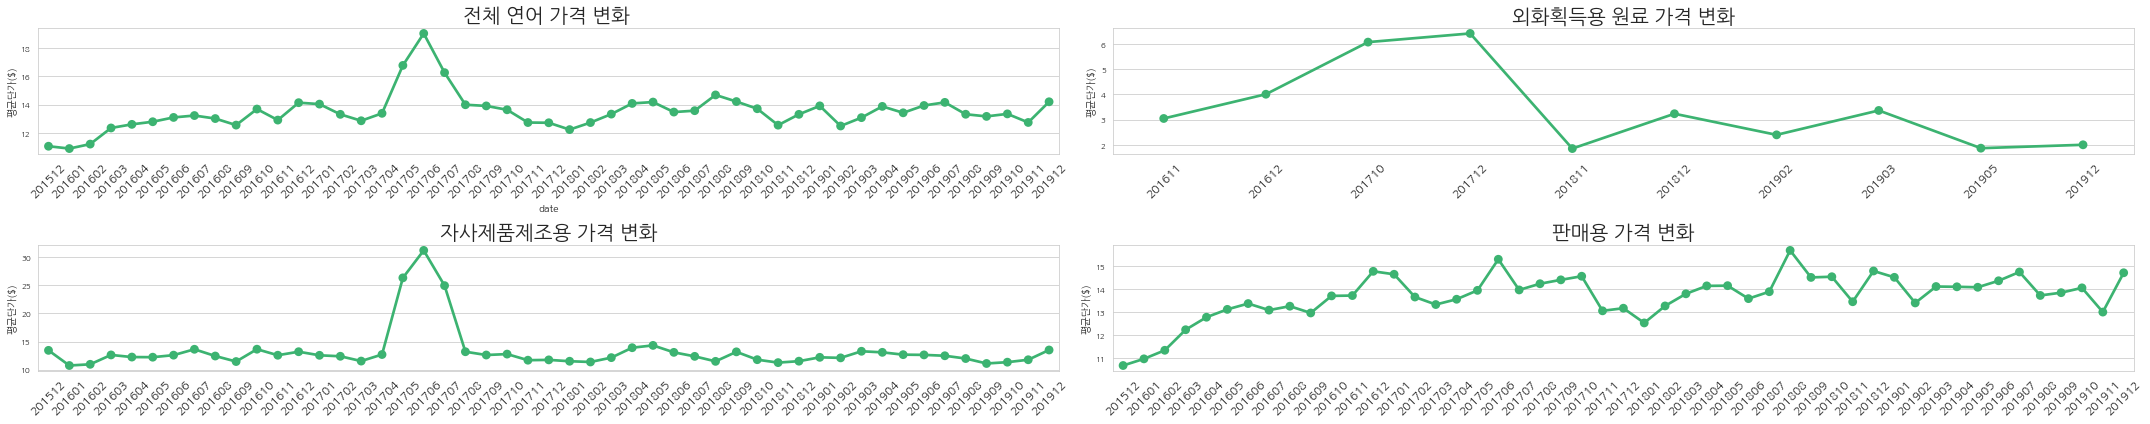

In [140]:
# 용도별 가격 정보

df_one = df_salmon['평균단가($)'].groupby(df_salmon['수입용도'])

plt.figure(figsize=(30, 6))

plt.subplot(221)
sns.pointplot(x='date', y='평균단가($)', data=df_salmon, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.title('전체 연어 가격 변화 ', fontsize=title_size)

is_one = df_salmon['수입용도'].str.contains("외화획득용 원료",na=False)
df_one = df_salmon[is_one]

plt.subplot(222)
sns.pointplot(x='date', y='평균단가($)', data=df_one, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('외화획득용 원료 가격 변화', fontsize=title_size)

is_one = df_salmon['수입용도'].str.contains("자사제품제조용",na=False)
df_one = df_salmon[is_one]

plt.subplot(223)
sns.pointplot(x='date', y='평균단가($)', data=df_one, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('자사제품제조용 가격 변화', fontsize=title_size)

is_one = df_salmon['수입용도'].str.contains("판매용",na=False)
df_one = df_salmon[is_one]

plt.subplot(224)
sns.pointplot(x='date', y='평균단가($)', data=df_one, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('판매용 가격 변화', fontsize=title_size)

plt.tight_layout()

- 17년 5~6월에 연어 평균단가가 급격히 상승.
- 같은 기간 판매용, 자사제품제조용 가격이 상승한 것이 가격 상승의 이유로 추정됨.

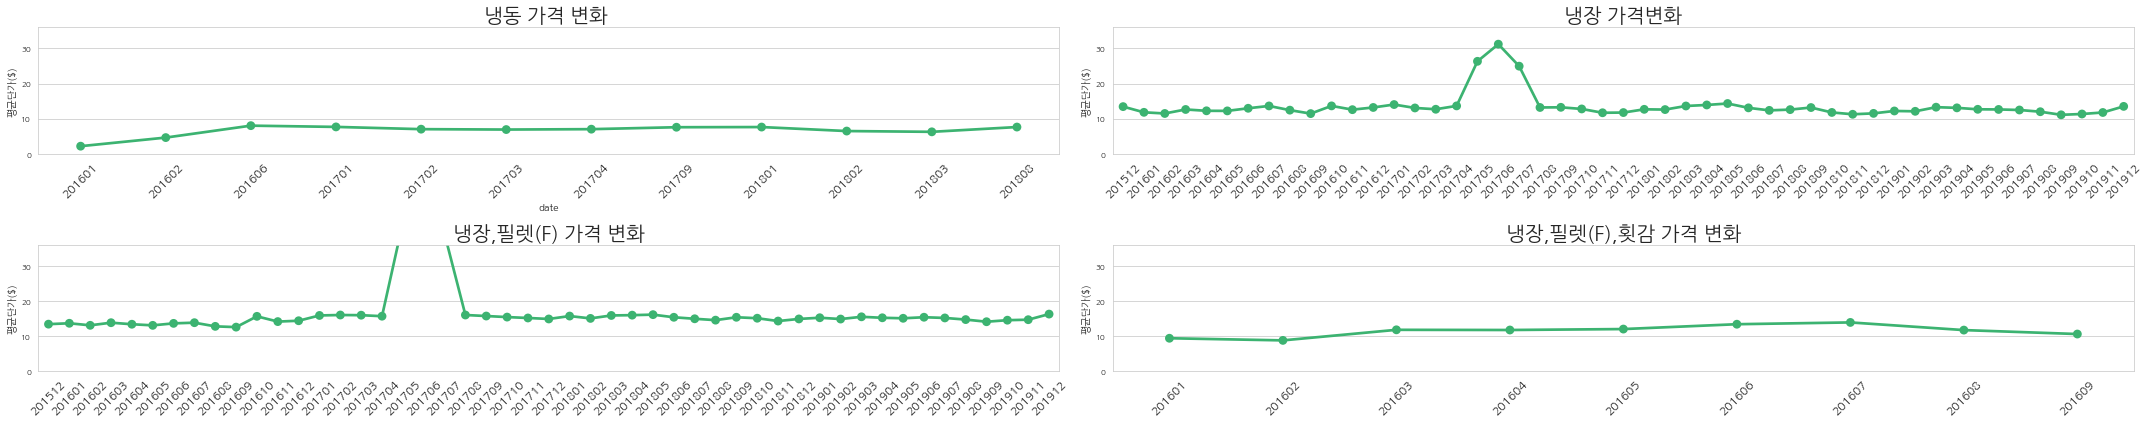

In [141]:
# 자사제품제조용으로 p_import_type 분석

is_one = df_salmon['수입용도'].str.contains("자사제품제조용",na=False)
df_one = df_salmon[is_one]

df_one

df_two = df_one['평균단가($)'].groupby(df_one['수입형태'])

plt.figure(figsize=(30, 6))

is_one = df_one['수입형태'].str.contains("냉동",na=False)
df_two = df_one[is_one]

plt.subplot(221)
sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.title('냉동 가격 변화 ', fontsize=title_size)
plt.ylim(0,36)

is_one = df_one['수입형태'].str.contains("냉장",na=False)
df_two = df_one[is_one]

plt.subplot(222)
sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('냉장 가격변화', fontsize=title_size)
plt.ylim(0,36)

is_one = df_one['수입형태'].str.contains("냉장,필렛",na=False)
df_two = df_one[is_one]

plt.subplot(223)
# plt.plot(df_two['date'],df_two['P_PRICE'])

sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('냉장,필렛(F) 가격 변화', fontsize=title_size)
plt.ylim(0,36)

is_one = df_one['수입형태'].str.contains("횟감",na=False)
df_two = df_one[is_one]

plt.subplot(224)
sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('냉장,필렛(F),횟감 가격 변화', fontsize=title_size)
plt.ylim(0,36)

plt.tight_layout()

- 냉장,필렛(F),횟감은 16년도, 냉동은 16,17,18년도 데이터만 존재.
- 자사제품제조용의 수입형태별 연어 평균단가 조사 결과, 냉장 및 냉장,필렛(F)의 평균단가가 17년 5 ~ 6월에 상승하여 17년 5 ~ 6월 평균단가가 상승한 것으로 보임.

In [58]:
df_train[df_train['상세어종']=='연어']['제조국'].value_counts()/sum(df_train[df_train['상세어종']=='연어']['제조국'].value_counts()) 

노르웨이     0.858294
영국       0.080591
캐나다      0.034251
호주       0.008059
러시아      0.007388
미국       0.003358
칠레       0.002015
아이슬란드    0.002015
뉴질랜드     0.002015
아일랜드     0.001343
베트남      0.000672
Name: 제조국, dtype: float64

In [59]:
df_train[df_train['상세어종']=='연어']['수출국'].value_counts()/sum(df_train[df_train['상세어종']=='연어']['수출국'].value_counts()) 

노르웨이     0.857623
영국       0.080591
캐나다      0.034251
호주       0.008059
러시아      0.007388
미국       0.002686
칠레       0.002015
아이슬란드    0.002015
뉴질랜드     0.002015
아일랜드     0.001343
베트남      0.001343
중국       0.000672
Name: 수출국, dtype: float64

In [115]:
# 제조국, 수출국 다른곳 찾기
print(df_salmon['comp'].value_counts())

같음    1867
다름      38
Name: comp, dtype: int64


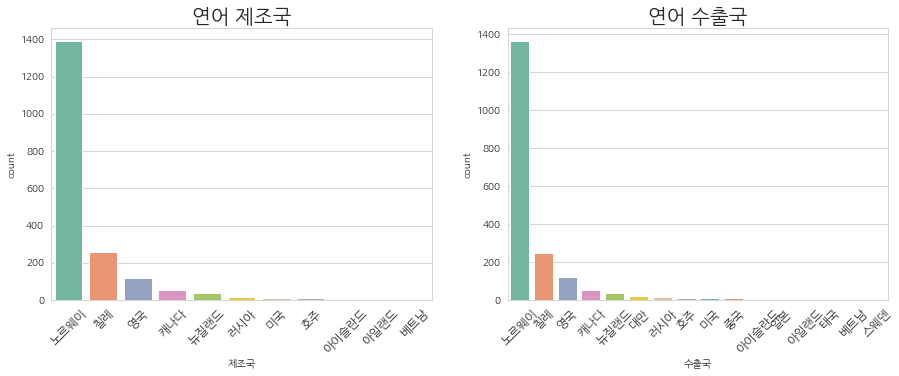

In [139]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(df_salmon['제조국'].astype('str').sort_values(), palette=color_palette, order= df_salmon['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 제조국', fontsize=title_size)

plt.subplot(122)
sns.countplot(df_salmon['수출국'].astype('str').sort_values(), palette=color_palette, order= df_salmon['수출국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 수출국', fontsize=title_size)

plt.show()

- 연어 제조국 및 수출국 점유율
- 노르웨이 독점시장 (85%)

In [61]:
all_salmon_price = df_train[df_train['상세어종']=='연어'].groupby(by='기준일').mean()['평균단가($)'] # 전체 연어 평균단가
norway_salmon_price = df_train[df_train['상세어종']=='연어'][df_train['수출국']=='노르웨이'].groupby(by='기준일').mean()['평균단가($)'] # 노르웨이 연어 평균단가

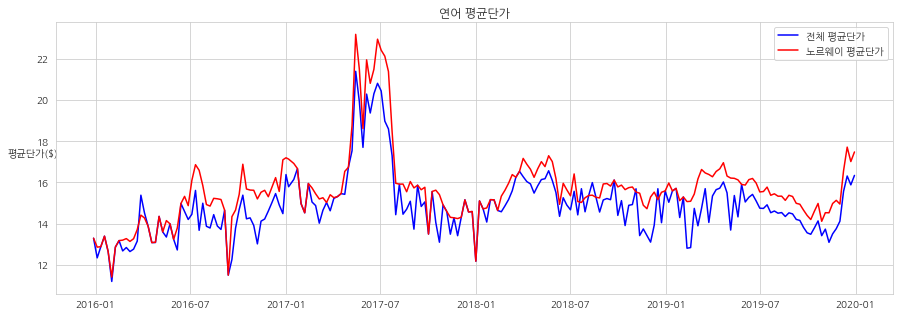

In [62]:
plt.figure(figsize=(15,5))

plt.title('연어 평균단가')

plt.plot(all_salmon_price,color='blue',label='전체 평균단가')
plt.plot(df_train[df_train['상세어종']=='연어'][df_train['수출국']=='노르웨이'].groupby(by='기준일').mean(),color='red',label='노르웨이 평균단가')

plt.legend(loc='best')
plt.ylabel('평균단가($)',rotation=0)

plt.show()

연어 평균단가는 **주요 수출국(노르웨이)의 평균단가와 높은 상관관계**를 가지는 듯함. (올라갈때 같이 올라가고 내려갈때 같이 내려감)

<AxesSubplot:title={'center':'Correlation of Salmon Price'}>

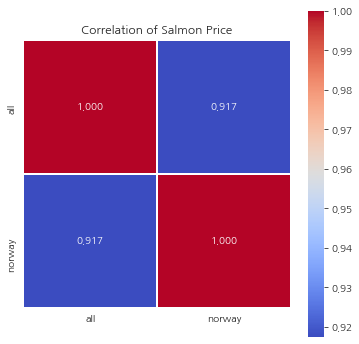

In [147]:
corr = pd.DataFrame({'all':all_salmon_price,
             'norway':norway_salmon_price
             }).corr()
plt.figure(figsize= (6, 6))
plt.title('Correlation of Salmon Price')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

실제로 연어 평균단가는 노르웨이 평균단가와 높은 상관관계를 띄고 있음.

In [64]:
all_salmon_count = df_train[df_train['상세어종']=='연어'].groupby(by='기준일')['상세어종'].count() # 전체 연어 수입량
norway_salmon_count = df_train[df_train['상세어종']=='연어'][df_train['수출국']=='노르웨이'].groupby(by='기준일')['상세어종'].count() # 노르웨이 연어 수입량

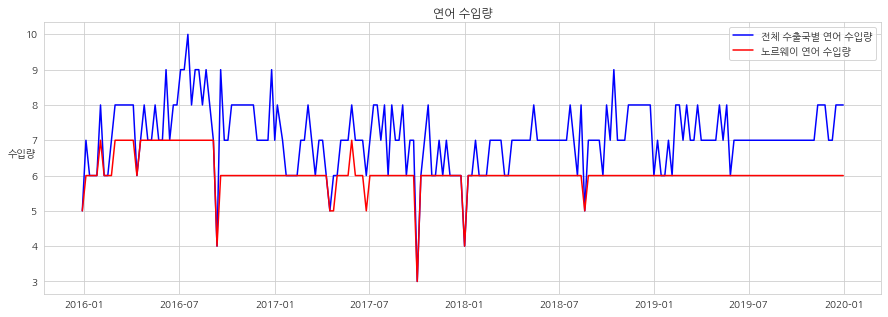

In [65]:
plt.figure(figsize=(15,5))

plt.title('연어 수입량')

plt.plot(all_salmon_count,color='blue',label='전체 수출국별 연어 수입량')
plt.plot(norway_salmon_count,color='red',label='노르웨이 연어 수입량')

plt.legend(loc='best')
plt.ylabel('수입량',rotation=0)

plt.show()

연어 수입량은 노르웨이 수입량과 높은 상관관계를 띄는 것으로 보임.

<AxesSubplot:title={'center':'Correlation of Salmon Import Volume'}>

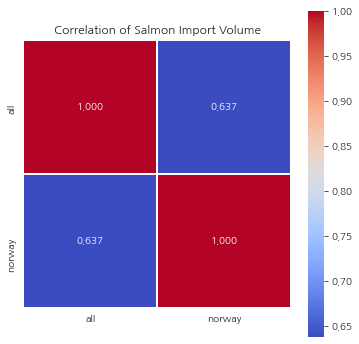

In [148]:
corr = pd.DataFrame({'all':all_salmon_count,
             'norway':norway_salmon_count
             }).corr()

plt.figure(figsize= (6, 6))
plt.title('Correlation of Salmon Import Volume')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

실제로 연어 수입량은 노르웨이 수입량과 높은 상관관계를 띄고 있음.

#### 새우

In [144]:
# 새우만 분류
is_shrimp = df_train['상세어종'].str.contains("새우",na=False)
df_shrimp = df_train[is_shrimp]

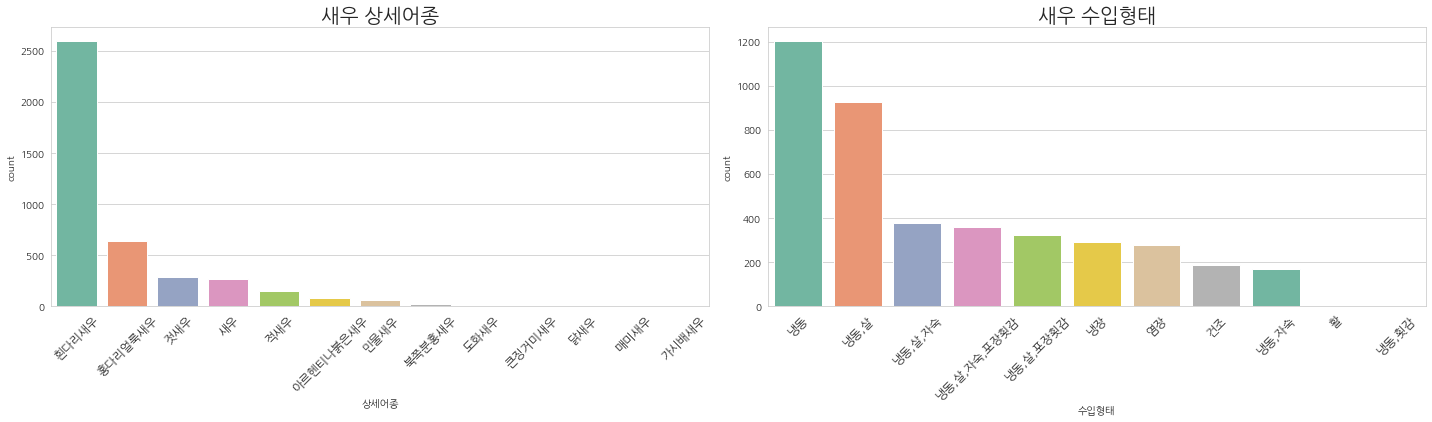

In [145]:
# 새우 제조국과 수출국 동일 여부 판단

df_shrimp.loc[df_shrimp['제조국']==df_shrimp['수출국'], "comp"] = '같음'
df_shrimp.loc[df_shrimp['제조국']!=df_shrimp['수출국'], "comp"] = '다름'

plt.figure(figsize=(20, 10))

plt.subplot(221)
sns.countplot(df_shrimp['상세어종'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['상세어종'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 상세어종', fontsize=title_size)

plt.subplot(222)
sns.countplot(df_shrimp['수입형태'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['수입형태'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 수입형태', fontsize=title_size)

plt.tight_layout()

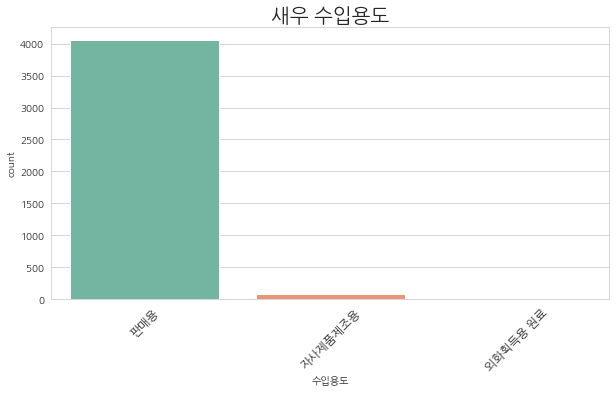

In [143]:
plt.figure(figsize=(10, 5))

sns.countplot(df_shrimp['수입용도'].astype('str').sort_values(), palette=color_palette, order= df_salmon['수입용도'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 수입용도', fontsize=title_size)
plt.show()

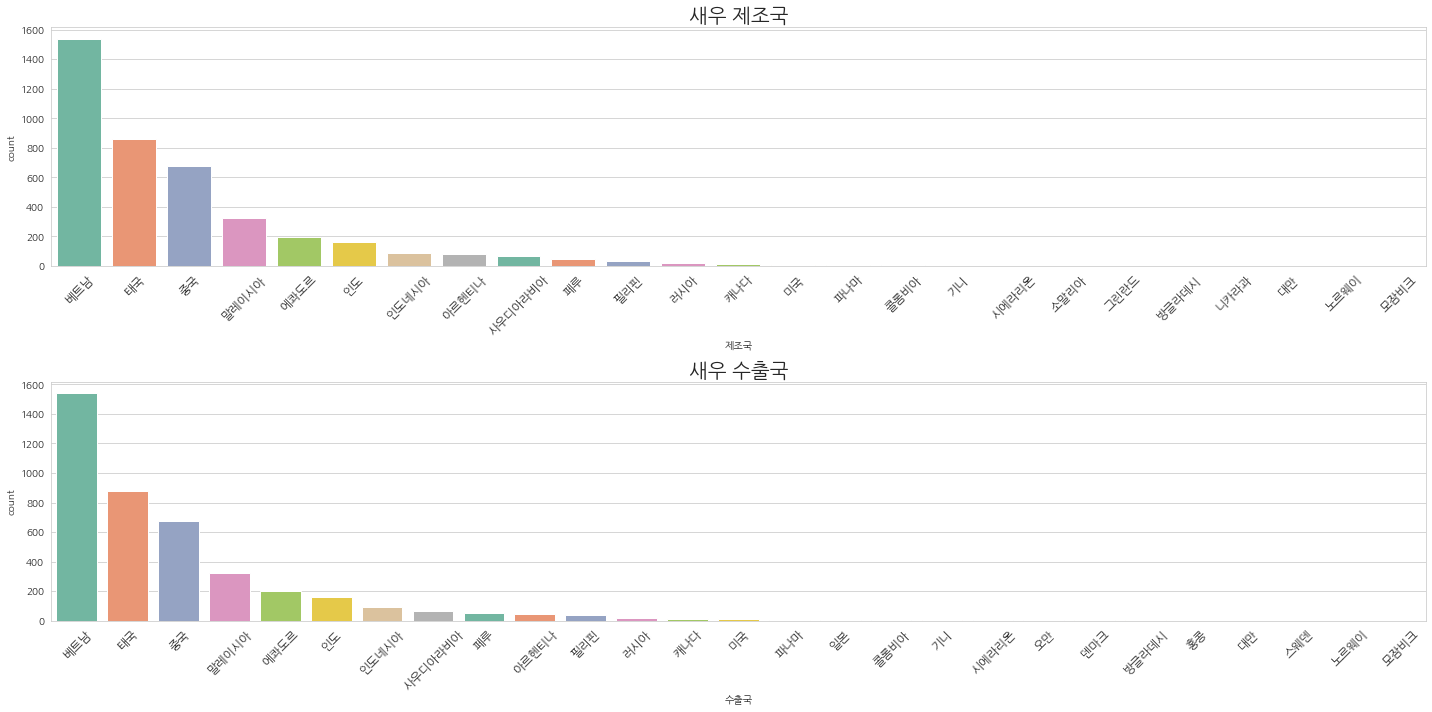

In [72]:
plt.figure(figsize=(20, 10))

plt.subplot(211)
sns.countplot(df_shrimp['제조국'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 제조국', fontsize=title_size)

plt.subplot(212)
sns.countplot(df_shrimp['수출국'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['수출국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 수출국', fontsize=title_size)

plt.tight_layout()

#####  흰다리새우

In [75]:
df_train[df_train['상세어종']=='흰다리새우']['제조국'].value_counts()/sum(df_train[df_train['상세어종']=='흰다리새우']['제조국'].value_counts()) 

베트남        0.391388
태국         0.284890
에콰도르       0.076125
말레이시아      0.073433
중국         0.061899
인도         0.039600
사우디아라비아    0.025375
인도네시아      0.022684
페루         0.018839
파나마        0.002691
필리핀        0.001538
콜롬비아       0.001538
Name: 제조국, dtype: float64

In [76]:
df_train[df_train['상세어종']=='흰다리새우']['수출국'].value_counts()/sum(df_train[df_train['상세어종']=='흰다리새우']['수출국'].value_counts()) 

베트남        0.389466
태국         0.284890
에콰도르       0.076125
말레이시아      0.073433
중국         0.061899
인도         0.039600
사우디아라비아    0.025375
인도네시아      0.022684
페루         0.018839
파나마        0.002691
일본         0.001922
필리핀        0.001538
콜롬비아       0.001538
Name: 수출국, dtype: float64

In [146]:
print(df_shrimp['comp'].value_counts())

같음    4085
다름      46
Name: comp, dtype: int64


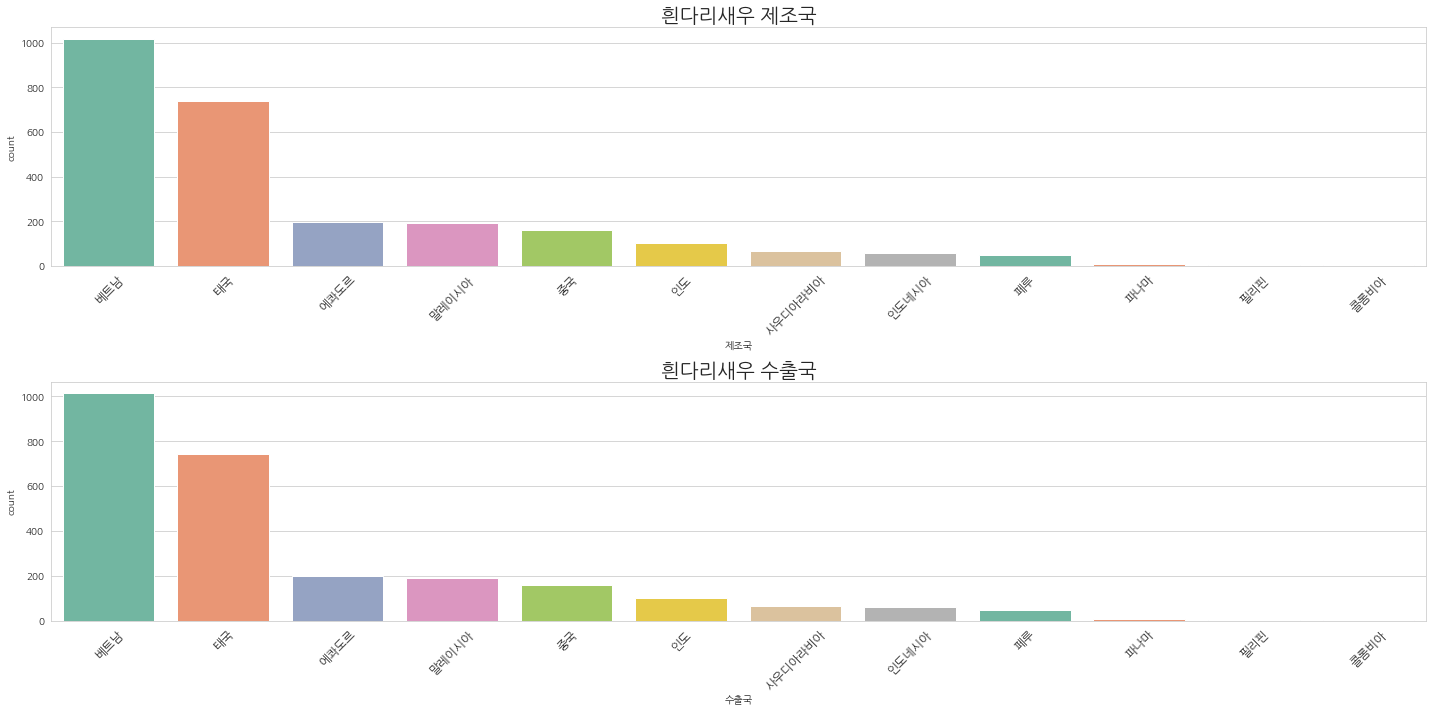

In [77]:
plt.figure(figsize=(20, 10))

plt.subplot(211)
sns.countplot(df_train[df_train['상세어종']=='흰다리새우']['제조국'].astype('str').sort_values(), palette=color_palette, order= df_train[df_train['상세어종']=='흰다리새우']['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('흰다리새우 제조국', fontsize=title_size)

plt.subplot(212)
sns.countplot(df_train[df_train['상세어종']=='흰다리새우']['수출국'].astype('str').sort_values(), palette=color_palette, order= df_train[df_train['상세어종']=='흰다리새우']['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('흰다리새우 수출국', fontsize=title_size)

plt.tight_layout()

- 흰다리새우 제조국 및 수출국 점유율
- 흰다리새우 주요 제조국 및 수출국 : 베트남,태국(60%)

In [78]:
all_Whiteleg_shrimp_price = df_train[df_train['상세어종']=='흰다리새우'].groupby(by='기준일')['평균단가($)'].mean() # 전체 흰다리새우 평균단가
vitenam_Whiteleg_shrimp_price = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='베트남'].groupby(by='기준일')['평균단가($)'].mean() # 베트남 흰다리새우 평균단가
thai_Whiteleg_shrimp_price = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='태국'].groupby(by='기준일')['평균단가($)'].mean() # 태국 흰다리새우 평균단가

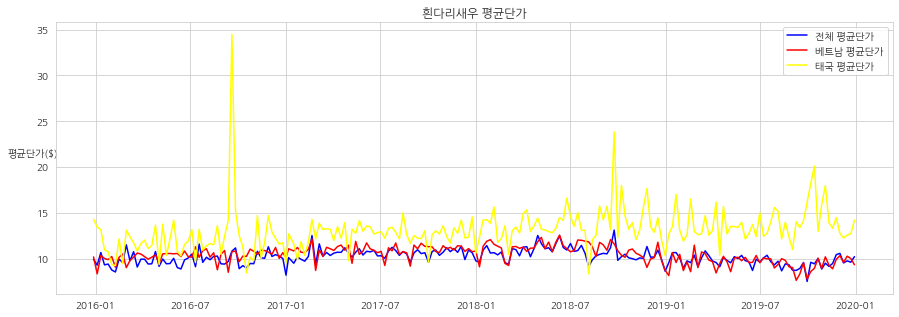

In [79]:
plt.figure(figsize=(15,5))

plt.title('흰다리새우 평균단가')

plt.plot(all_Whiteleg_shrimp_price,color='blue',label='전체 평균단가')
plt.plot(vitenam_Whiteleg_shrimp_price,color='red',label='베트남 평균단가')
plt.plot(thai_Whiteleg_shrimp_price,color='yellow',label='태국 평균단가')

plt.legend(loc='best')
plt.ylabel('평균단가($)',rotation=0)

plt.show()

흰다리새우 평균단가는 **주요 수출국들(베트남,태국)의 평균단가와 높은 상관관계**를 가지는 듯함

<AxesSubplot:title={'center':'Correlation of Whiteleg Price'}>

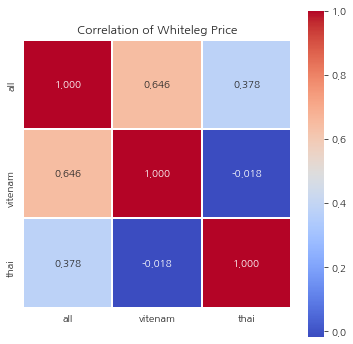

In [150]:
corr = pd.DataFrame({'all':all_Whiteleg_shrimp_price,
             'vitenam':vitenam_Whiteleg_shrimp_price,
              'thai':thai_Whiteleg_shrimp_price
             }).corr() 

plt.figure(figsize= (6, 6))
plt.title('Correlation of Whiteleg Price')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

실제로 흰다리새우 평균단가는 베트남,태국 평균단가와 높은 상관관계를 띄고 있음.

In [81]:
all_Whiteleg_shrimp_count = df_train[df_train['상세어종']=='흰다리새우'].groupby(by='기준일')['상세어종'].count() # 전체 흰다리새우 수입량
vitenam_Whiteleg_shrimp_count = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='베트남'].groupby(by='기준일')['상세어종'].count() # 베트남 흰다리새우 수입량
thai_Whiteleg_shrimp_count = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='태국'].groupby(by='기준일')['상세어종'].count() # 태국 흰다리새우 수입량

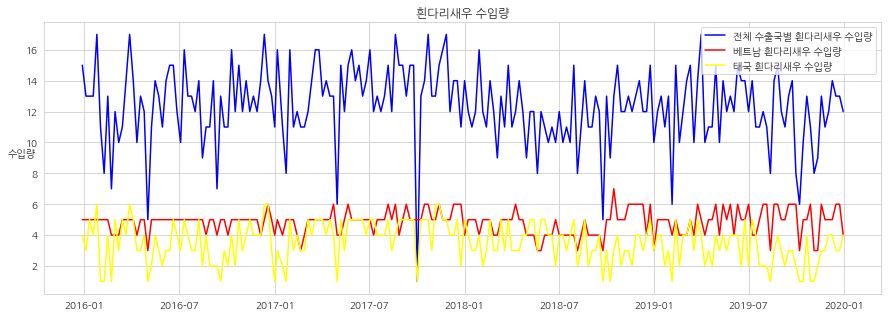

In [82]:
plt.figure(figsize=(15,5))

plt.title('흰다리새우 수입량')

plt.plot(all_Whiteleg_shrimp_count ,color='blue',label='전체 수출국별 흰다리새우 수입량')
plt.plot(vitenam_Whiteleg_shrimp_count ,color='red',label='베트남 흰다리새우 수입량')
plt.plot(thai_Whiteleg_shrimp_count,color='yellow',label='태국 흰다리새우 수입량')


plt.legend(loc='best')
plt.ylabel('수입량',rotation=0)

plt.show()

흰다리새우 수입량은 주요 수출국별(베트남,태국) 수입량과 높은 상관관계를 띄는 것으로 보임.

<AxesSubplot:title={'center':'Correlation of Whiteleg Shrimp Import Volume'}>

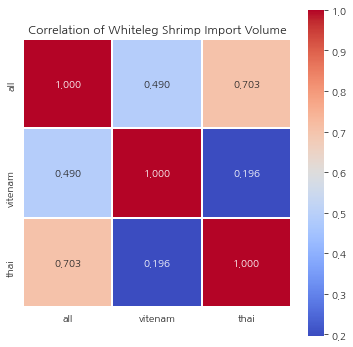

In [149]:
corr = pd.DataFrame({'all':all_Whiteleg_shrimp_count,
             'vitenam':vitenam_Whiteleg_shrimp_count,
              'thai':thai_Whiteleg_shrimp_count
             }).corr()

plt.figure(figsize= (6, 6))
plt.title('Correlation of Whiteleg Shrimp Import Volume')
sns.heatmap(corr, cmap='coolwarm', fmt='.3f', annot=True, 
            linewidths = 0.1, linecolor='white', square = True)

실제로 흰다리새우 수입량은 주요 수출국별(베트남,태국) 수입량과 높은 상관관계를 띄는 것으로 보임.

### 시계열

#### Setting

In [84]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [85]:
def adf_test(y):
    print("Results of Augmented Dickey-Fuller test:")
    dftest = adfuller(y,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['test statistic','p-value','# of lags','# of observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

#### 오징어

In [86]:
adf_test(all_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.282189
p-value                   0.177777
# of lags                 4.000000
# of observations       203.000000
Critical Value (1%)      -3.462980
Critical Value (5%)      -2.875885
Critical Value (10%)     -2.574416
dtype: float64


In [87]:
adf_test(peru_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.834459
p-value                   0.053518
# of lags                14.000000
# of observations       182.000000
Critical Value (1%)      -3.466800
Critical Value (5%)      -2.877555
Critical Value (10%)     -2.575308
dtype: float64


In [88]:
adf_test(china_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.852497
p-value                   0.051157
# of lags                 4.000000
# of observations       188.000000
Critical Value (1%)      -3.465620
Critical Value (5%)      -2.877040
Critical Value (10%)     -2.575032
dtype: float64


In [89]:
adf_test(chile_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -1.817471
p-value                   0.371823
# of lags                 2.000000
# of observations       173.000000
Critical Value (1%)      -3.468726
Critical Value (5%)      -2.878396
Critical Value (10%)     -2.575756
dtype: float64


In [90]:
adf_test(all_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.496217
p-value                   0.000002
# of lags                 1.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


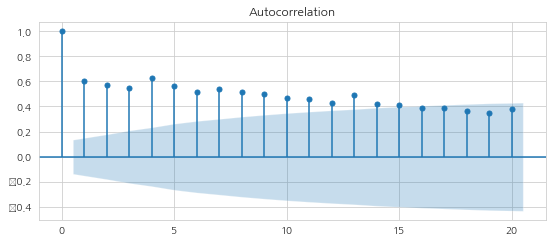

In [91]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_squid_price,lags=20,ax=ax1) # 0으로 느리게 감소 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

In [92]:
adf_test(peru_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.474553
p-value                   0.008665
# of lags                 3.000000
# of observations       193.000000
Critical Value (1%)      -3.464694
Critical Value (5%)      -2.876635
Critical Value (10%)     -2.574816
dtype: float64


In [93]:
adf_test(china_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -4.442649
p-value                   0.000249
# of lags                 1.000000
# of observations       191.000000
Critical Value (1%)      -3.465059
Critical Value (5%)      -2.876794
Critical Value (10%)     -2.574901
dtype: float64


In [94]:
adf_test(chile_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.177519
p-value                   0.000010
# of lags                 2.000000
# of observations       173.000000
Critical Value (1%)      -3.468726
Critical Value (5%)      -2.878396
Critical Value (10%)     -2.575756
dtype: float64


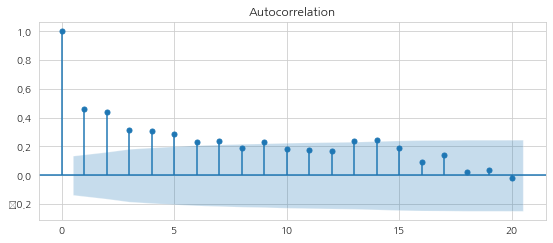

In [95]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_squid_count,lags=20,ax=ax1)

#### 연어

In [96]:
adf_test(all_salmon_price) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.402312
p-value                   0.010880
# of lags                 3.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


In [97]:
adf_test(norway_salmon_price) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.414652
p-value                   0.010469
# of lags                 3.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


In [98]:
adf_test(all_salmon_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.075966
p-value                   0.000016
# of lags                 2.000000
# of observations       207.000000
Critical Value (1%)      -3.462342
Critical Value (5%)      -2.875606
Critical Value (10%)     -2.574267
dtype: float64


In [99]:
adf_test(norway_salmon_count) # p-value가 0.05보다 크므로 귀무가설 기각 x -> 정상성 만족 x --> 로그 변환 or 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.509735
p-value                   0.113124
# of lags                 6.000000
# of observations       203.000000
Critical Value (1%)      -3.462980
Critical Value (5%)      -2.875885
Critical Value (10%)     -2.574416
dtype: float64


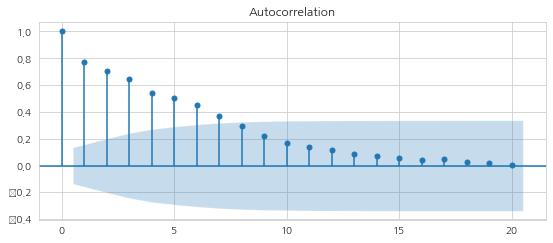

In [100]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_salmon_price,lags=20,ax=ax1) # 0으로 빠르게 감소 --> 정상성 만족

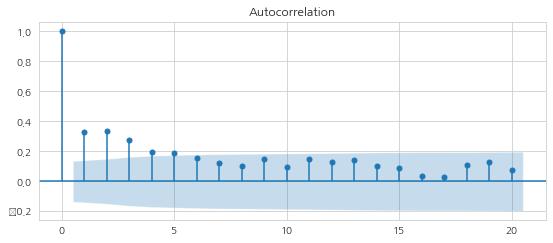

In [101]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_salmon_count,lags=20,ax=ax1)

#### 흰다리새우

In [102]:
adf_test(all_Whiteleg_shrimp_price) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.814197
p-value                   0.002765
# of lags                 3.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


In [103]:
adf_test(vitenam_Whiteleg_shrimp_price)  # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -1.599229
p-value                   0.483981
# of lags                 7.000000
# of observations       201.000000
Critical Value (1%)      -3.463309
Critical Value (5%)      -2.876029
Critical Value (10%)     -2.574493
dtype: float64


In [104]:
adf_test(thai_Whiteleg_shrimp_price)  # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic         -7.790862e+00
p-value                 7.949013e-12
# of lags               1.000000e+00
# of observations       2.070000e+02
Critical Value (1%)    -3.462342e+00
Critical Value (5%)    -2.875606e+00
Critical Value (10%)   -2.574267e+00
dtype: float64


In [105]:
adf_test(all_Whiteleg_shrimp_count)  # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic         -6.161200e+00
p-value                 7.166996e-08
# of lags               5.000000e+00
# of observations       2.040000e+02
Critical Value (1%)    -3.462818e+00
Critical Value (5%)    -2.875815e+00
Critical Value (10%)   -2.574379e+00
dtype: float64


In [106]:
adf_test(vitenam_Whiteleg_shrimp_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -4.583956
p-value                   0.000138
# of lags                 5.000000
# of observations       203.000000
Critical Value (1%)      -3.462980
Critical Value (5%)      -2.875885
Critical Value (10%)     -2.574416
dtype: float64


In [107]:
adf_test(thai_Whiteleg_shrimp_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.279234
p-value                   0.000006
# of lags                 4.000000
# of observations       204.000000
Critical Value (1%)      -3.462818
Critical Value (5%)      -2.875815
Critical Value (10%)     -2.574379
dtype: float64


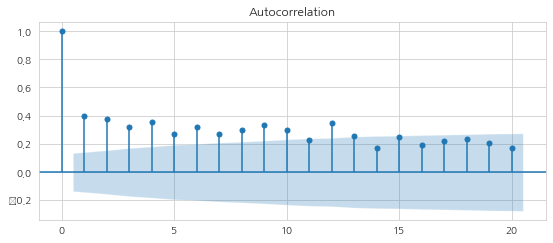

In [108]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_Whiteleg_shrimp_price,lags=20,ax=ax1)

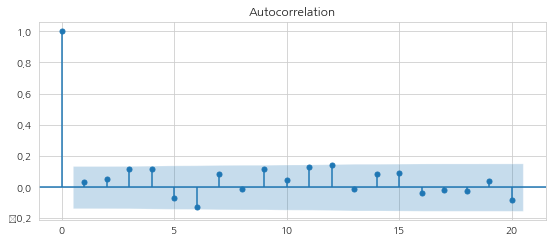

In [109]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_Whiteleg_shrimp_count,lags=20,ax=ax1)

분석 방향

1. 전체 제조국 및 수출국을 포함한 모델

2. 주요 수출국들(노르웨이,태국,베트남,중국,칠레,페루)만을 포함한 모델

3. 주요 수출국별 주요 어종 모델 (오징어, 연어, 흰다리새우)

4. 시계열 모델

위 4가지 모델로 분석을 진행하여 모델 검증을 통해 가장 설명력이 좋은 모델을 선택하여 수산물 가격 예측을 수행하고자 함.